In [56]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [57]:
import numpy as np
import pandas as pd

In [58]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [126]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [127]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [128]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [129]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [130]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [131]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [134]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [135]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [110]:
# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (lastdate)
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print("One year before last date available: ", one_year_ago)

('2017-08-23',)
One year before last date available:  2016-08-23


In [111]:
# Perform a query to retrieve the data and precipitation scores
last_12_months_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >=
'2016-08-23').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date columnl
last12months_precipitation_df=pd.DataFrame(last_12_months_precipitation).rename(columns={"date":"Date","prcp":"Precipitation"})
last12months_precipitation_df.head()
# Sort the dataframe by date
last12months_precipitation_df = last12months_precipitation_df.set_index("Date")
last12months_precipitation_df.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


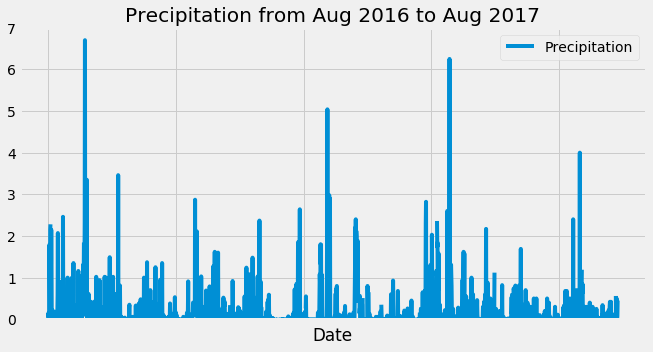

In [176]:
# Use Pandas Plotting with Matplotlib to plot the data
last12months_precipitation_df.plot(figsize=(10,5),ylim=(0,7),title=f'Precipitation from Aug 2016 to Aug 2017')
plt.savefig("Precipitation_Analysis.jpg")
plt.show()

In [113]:
# Use Pandas to calculate the summary statistics for the precipitation data
last12months_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [114]:
# Design a query to show how many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print(location_station)

9


In [136]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mostactive_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
for station, count in mostactive_stations:
    print("Station:",station,count,)

Station: USC00519281 2772
Station: USC00519397 2724
Station: USC00513117 2709
Station: USC00519523 2669
Station: USC00516128 2612
Station: USC00514830 2202
Station: USC00511918 1979
Station: USC00517948 1372
Station: USC00518838 511


[]

In [140]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best_station = mostactive_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [141]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= one_year_ago).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()


,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

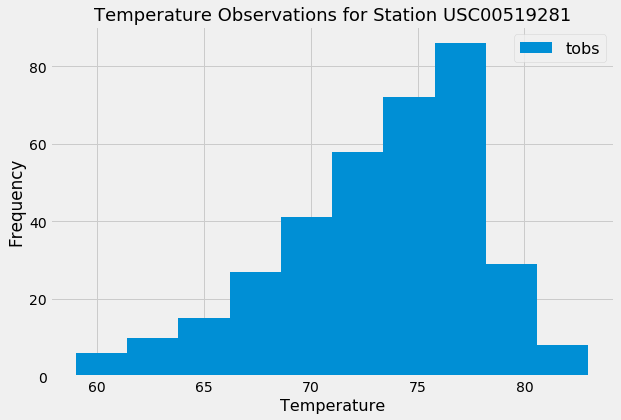

In [156]:
tobs_df.plot.hist(by='station', figsize=(9,6))
plt.title("Temperature Observations for Station " + best_station, fontsize=18)
plt.xlabel("Temperature", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("StationTemps.png")
plt.show

In [157]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-03-21', '2017-03-28')
trip_results

[(69.0, 74.23404255319149, 80.0)]

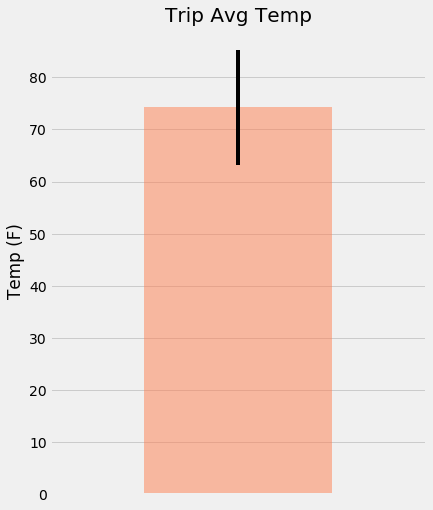

In [171]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.savefig("TripTempSummary.png")
plt.show()